## Cytokine impact on macrophage

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from sklearn import linear_model
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import rpy2
%load_ext rpy2.ipython
import glob
import os
from matplotlib_venn import venn2, venn2_circles

In [16]:
# read cytokines
with open('data/cytokine_list/Cytokine cytokine receptor interaction.txt') as handle:
    cytokine_list = [l.strip() for l in handle]
# read receptor ligands
with open('data/cytokine_list/Surface gene (ligand).txt') as handle:
    ligand_list = [l.strip() for l in handle]
# read receptor
with open('data/cytokine_list/Surface gene (receptor).txt') as handle:
    surf_list = [l.strip() for l in handle]
# merge all genes
cytokine_list_mouse = [s[0]+s[1:].lower() for s in cytokine_list]
ligand_list_mouse = [s[0]+s[1:].lower() for s in ligand_list]
surf_list_mouse = [s[0]+s[1:].lower() for s in surf_list]
#cytokine_related = list((set(cytokine_list) & set(surf_list)) - set(ligand_list))
cytokine_related = list((set(cytokine_list) | set(surf_list)) | set(ligand_list))
cytokine_related_mouse = [s[0]+s[1:].lower() for s in cytokine_related]

In [17]:
def venn_diagram(len_intersect, len_set1, len_set2, name1, name2, title=''):
    overlap = (len_set1 - len_intersect, len_set2 - len_intersect, len_intersect)

    # plot venn diagram
    with sns.plotting_context('paper', font_scale=1.5):
        venn2(subsets=overlap, set_labels=(name1, name2))
        venn2_circles(subsets=overlap, linestyle='solid', linewidth=.75)
        plt.title(title, size=26)
        
    return overlap

### Differential RNA-seq

In this section we look at all of the differential cytokines from the RNA-seq. First step look at genes without IFNG treatment

In [18]:
# read in RNA-seq data
rna_diff = pd.read_csv('data/deseq2_cop1_only/Condition/Condition_Cop1KoSg_VS_Rosa26_Cop1_DESeq2_ConvertID.txt',  sep='\t')
rna_diff = rna_diff.reset_index().rename(columns={'index': 'gene'})

# get differential cytokines
rna_diff['human_gene'] = rna_diff['gene'].str.upper()
is_cytokine = rna_diff['human_gene'].isin(cytokine_related)
diff_gene_list = rna_diff[is_cytokine & (rna_diff['padj']<0.05) & (rna_diff['log2FoldChange']<0)]['human_gene'].values.tolist()
diff_gene_list_mouse = rna_diff[is_cytokine & (rna_diff['padj']<0.05) & (rna_diff['log2FoldChange']<0)]['gene'].values.tolist()
diff_gene_list_all_mouse = rna_diff[(rna_diff['padj']<0.05) & (rna_diff['log2FoldChange']<0)]['gene'].values.tolist()

Next, we look at differential RNA-seq *with* treatment of IFNG.

In [19]:
# read in RNA-seq data
ifn_rna_diff = pd.read_csv('data/deseq2_cop1_only/Condition/Condition_Cop1KoSg_IFNg_VS_Rosa26_IFNg_Cop1_DESeq2_ConvertID.txt',  sep='\t')
ifn_rna_diff = ifn_rna_diff.reset_index().rename(columns={'index': 'gene'})

# get differential cytokines
ifn_rna_diff['human_gene'] = ifn_rna_diff['gene'].str.upper()
is_cytokine = ifn_rna_diff['human_gene'].isin(cytokine_related)
ifn_diff_gene_list = ifn_rna_diff[is_cytokine & (ifn_rna_diff['padj']<0.05) & (ifn_rna_diff['log2FoldChange']<0)]['human_gene'].values.tolist()
ifn_diff_gene_list_mouse = ifn_rna_diff[is_cytokine & (ifn_rna_diff['padj']<0.05) & (ifn_rna_diff['log2FoldChange']<0)]['gene'].values.tolist()
ifn_diff_gene_list_all_mouse = ifn_rna_diff[(ifn_rna_diff['padj']<0.05) & (ifn_rna_diff['log2FoldChange']<0)]['gene'].values.tolist()

Write each cytokine to a file for input into Tigger.

In [20]:
merged_list = set(ifn_diff_gene_list) | set(diff_gene_list)
merged_list_mouse = set(ifn_diff_gene_list_mouse) | set(diff_gene_list_mouse)
merged_list_all_mouse = set(ifn_diff_gene_list_all_mouse) | set(diff_gene_list_all_mouse)

### Examine regulatory potential of cytokines

In [21]:
def read_rp_file(mypath, name, skip_rows=5):
    rp = pd.read_csv(mypath, sep='\t', skiprows=skip_rows).rename(columns={'RPscore': 'score', '# Symbol': 'symbol'})
    rp = rp.sort_values('score', ascending=False).drop_duplicates(subset=['symbol'])
    rp = rp.set_index('symbol').rename(columns={'score': name})
    return rp
    
def read_rp(base_dir):
    concat_list = []
    mypattern = os.path.join(base_dir, '*')
    for d in glob.glob(mypattern):
        category = os.path.basename(d)
        rp = read_rp_file(os.path.join(d, '{}_gene_score_5fold.txt'.format(category)), category)
        concat_list.append(rp[category])
    concat_df = pd.concat(concat_list, axis=1)
    return concat_df

def read_rp_histone(base_dir):
    concat_list = []
    mypattern = base_dir + '*'
    for d in glob.glob(mypattern):
        category = os.path.basename(d)
        
        tmp = pd.read_csv(os.path.join(d, '{}_treat_pileup.txt'.format(category)), sep='\t', header=None, names=['chrom', 'start', 'end', 'tx_gene', 'score'])
        mysplit = tmp['tx_gene'].str.split(':', expand=True)
        tmp['symbol'] = mysplit[1]
        tmp = tmp.sort_values('score', ascending=False).drop_duplicates(subset=['symbol'])
        tmp = tmp.set_index('symbol').rename(columns={'score': category})
        
        concat_list.append(tmp[category])
    concat_df = pd.concat(concat_list, axis=1)
    return concat_df

rp = read_rp('data/RP')

rp_rank = 100*(rp.rank(ascending=True) / len(rp))
rp_max = rp.max()
rp_norm = rp.div(rp_max)
rp.head()

,COP1_KO_sgRNA1.rep1,COP1_KO_sgRNA1.rep2,COP1_KO_sgRNA2.rep1,COP1_KO_sgRNA2.rep2,ROSA.rep1,ROSA.rep2,WT2.rep1,WT2.rep2
symbol,,,,,,,,
Grn,4.020,2.642,0.537,0.460,2.560,3.020,3.031,2.492
Ankrd40,3.924,3.942,1.985,0.938,3.928,3.491,3.030,3.923
Zfp217,3.777,3.796,3.391,3.399,3.804,3.781,3.808,3.808
Anxa11,3.664,2.228,1.275,1.332,2.235,2.659,2.689,3.169
Tmem120b,3.497,2.138,0.625,0.021,2.415,2.423,2.417,2.420


In [22]:
cebpd_up_peak = read_rp_file('data/peaks/cop1_vs_rosa26/rp/up_peak_center_RP_result.txt', 'cebpd_up', skip_rows=8)
cebpd_down_peak = read_rp_file('data/peaks/cop1_vs_rosa26/rp/down_peak_center_RP_result.txt', 'cebpd_down', skip_rows=8)
cebpd_ifn_up_peak = read_rp_file('data/peaks/cop1_ifn_vs_rosa26_ifn/rp/up_peak_center_RP_result.txt', 'cebpd_up', skip_rows=8)
cebpd_ifn_down_peak = read_rp_file('data/peaks/cop1_ifn_vs_rosa26_ifn/rp/down_peak_center_RP_result.txt', 'cebpd_down', skip_rows=8)
cop1_ko_up_peak = read_rp_file('data/peaks/cebpd/rp/up_cop1_ko_RP_result_v2.txt', 'cebpd_up', skip_rows=8)
cop1_ko_down_peak = read_rp_file('data/peaks/cebpd/rp/down_cop1_ko_RP_result.txt', 'cebpd_up', skip_rows=8)
atac_up_peak_genes = cebpd_up_peak.head(500).index.values
atac_down_peak_genes = cebpd_down_peak.head(500).index.values
atac_ifn_up_peak_genes = cebpd_ifn_up_peak.head(500).index.values
atac_ifn_down_peak_genes = cebpd_ifn_down_peak.head(500).index.values
cebpd_up_peak_genes = cop1_ko_up_peak.head(500).index.values
cebpd_down_peak_genes = cop1_ko_down_peak.head(500).index.values

# cop1 ko rna-seq
ifn_cop1_down_genes = ifn_rna_diff.loc[(ifn_rna_diff['padj']<0.001) & (ifn_rna_diff['log2FoldChange']<0), 'gene'].unique()
ifn_cop1_up_genes = ifn_rna_diff.loc[(ifn_rna_diff['padj']<0.001) & (ifn_rna_diff['log2FoldChange']>0), 'gene'].unique()
cop1_down_genes = rna_diff.loc[(rna_diff['padj']<0.001) & (rna_diff['log2FoldChange']<0), 'gene'].unique()
cop1_up_genes = rna_diff.loc[(rna_diff['padj']<0.001) & (rna_diff['log2FoldChange']>0), 'gene'].unique()

In [27]:
#diff_expr = pd.read_csv('data/2021-03-29_Cebpd_KO/analysis/2021-03-30_Cebpd2_Rosa26_IFN.txt', sep='\t')
diff_expr = pd.read_csv('data/deseq2_cebpd_analysis/Condition/Condition_CebpdKoSg1_IFNg_VS_Rosa26_IFNg_DESeq2_ConvertID.txt', sep='\t')
#diff_expr = pd.read_csv('data/deseq2_cebpd_analysis/Condition/Condition_CebpdKoSg1_VS_Rosa26_DESeq2_ConvertID.txt', sep='\t')
is_signif = (diff_expr['padj']<0.001) & (diff_expr['log2FoldChange'].abs()>0.0)
is_up_reg = diff_expr['log2FoldChange']>0
is_down_reg = diff_expr['log2FoldChange']<0
upreg_genes = diff_expr[is_signif & is_up_reg].index.values
downreg_genes = diff_expr[is_signif & is_down_reg].index.values

cebpd_cols = ['WT2.rep1', 'WT2.rep2', 'ROSA.rep1', 'ROSA.rep2', 'COP1_KO_sgRNA1.rep1', 'COP1_KO_sgRNA1.rep2', 'COP1_KO_sgRNA2.rep1', 'COP1_KO_sgRNA2.rep2']
tmp = rp_rank.loc[:, cebpd_cols].mean(axis=1).sort_values(ascending=False)
top_cebpd_genes = tmp.head(1000).index.values

down_intersect = set(downreg_genes) & set(top_cebpd_genes)
up_intersect = set(upreg_genes) & set(top_cebpd_genes)

#down_intersect = set(downreg_genes) & set(cebpd_up_peak_genes)
#up_intersect = set(upreg_genes) & set(cebpd_up_peak_genes)

In [28]:
tot_genes = set(rna_diff['gene'].unique())
set1 = set(cop1_up_genes) & set(cytokine_related_mouse)
set2 = set(cop1_down_genes) & set(cytokine_related_mouse)
set3 = set(upreg_genes) & set(cytokine_related_mouse)
set4 = set(downreg_genes) & set(cytokine_related_mouse)
intersect = len(set(set1) & set(set2))
union = len(set(set1) | set(set2))
intersect / union
mymat = [[len(set1&set3), len(set3-set1)], [len(set1-set3), len((set(diff_expr.index.values)&set(cytokine_related_mouse)) - set1 - set3)]]
stats.fisher_exact(mymat)

(0.0, 1.0)

In [30]:
mymat

[[0, 15], [6, 232]]

/Users/ctokheim/conda/envs/data_analysis2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/ctokheim/conda/envs/data_analysis2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


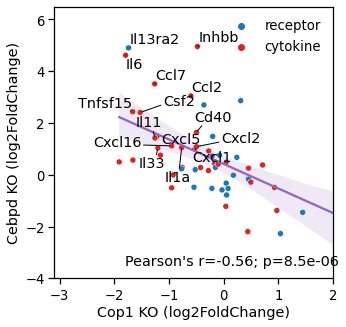

In [31]:
#tmp1 = rna_diff.loc[rna_diff['gene'].isin(cytokine_related_mouse), ['gene', 'log2FoldChange', 'padj']]
tmp1 = ifn_rna_diff.loc[ifn_rna_diff['gene'].isin(cytokine_related_mouse), ['gene', 'log2FoldChange', 'padj']]
tmp2 = diff_expr.reset_index().rename(columns={'index': 'gene'})
tmp2 = tmp2.loc[tmp2['gene'].isin(cytokine_related_mouse), ['gene', 'log2FoldChange', 'padj']]
tmp2 = tmp2.loc[:, ['gene', 'log2FoldChange', 'padj']]
tmp_merged = pd.merge(tmp1, tmp2, on='gene', how='inner', suffixes=(' Cop1_KO', ' Cebpd_KO'))

# add labels for cytokine/receptor
tmp_merged['type'] = 'cytokine'
tmp_merged.loc[tmp_merged['gene'].isin(surf_list_mouse), 'type'] = 'receptor'

with sns.plotting_context('notebook', font_scale=1.2):
    is_signif = (tmp_merged['padj Cop1_KO']<0.05) | (tmp_merged['padj Cebpd_KO']<0.05)
    sns.regplot('log2FoldChange Cop1_KO', 'log2FoldChange Cebpd_KO', data=tmp_merged[is_signif].dropna(), scatter=False, color=sns.color_palette().as_hex()[4])
    ax= sns.scatterplot('log2FoldChange Cop1_KO', 'log2FoldChange Cebpd_KO', 
                    data=tmp_merged[is_signif].dropna(), hue='type', palette=[sns.color_palette().as_hex()[0], sns.color_palette().as_hex()[3]] )
    plt.ylabel('Cebpd KO (log2FoldChange)')
    plt.xlabel('Cop1 KO (log2FoldChange)')
    plt.legend(loc='best', title='', frameon=False)
    plt.ylim(-4, 6.5)
    plt.xlim(-3.1, 2)
    
    # add gene labels
    txt_lbls=[
        ax.text(row['log2FoldChange Cop1_KO'], row['log2FoldChange Cebpd_KO'], row['gene'])
        for ix, row in tmp_merged[is_signif].dropna().iterrows()
        if row['log2FoldChange Cop1_KO']<-.45 and row['log2FoldChange Cebpd_KO']>1
    ]
    import adjustText
    adjustText.adjust_text(txt_lbls, arrowprops=dict(arrowstyle='-', color='black'))
    
    pearsons_r, pvalue = stats.pearsonr(tmp_merged[is_signif].dropna()['log2FoldChange Cop1_KO'], tmp_merged[is_signif].dropna()['log2FoldChange Cebpd_KO'])
    plt.text(-1.8, -3.5, 'Pearson\'s r={:.2g}; p={:.2g}'.format(pearsons_r, pvalue))
    plt.gcf().set_size_inches(5, 5)

    #plt.savefig('figures/cebpd_cop1_cytokine_corr_v2.pdf')


In [90]:
is_signif_both = (tmp_merged['padj Cop1_KO']<0.05) & (tmp_merged['padj Cebpd_KO']<0.05)
tmp_merged[is_signif & (tmp_merged['log2FoldChange Cop1_KO']<0) & (tmp_merged['log2FoldChange Cebpd_KO']>0)].dropna().to_clipboard(sep='\t')

### Raw overlap of DEGs between Cop1 KO and Cebpd KO

In [3]:
# read in Cop1 results
ifn_rna_diff = pd.read_csv('data/deseq2_cop1_only/Condition/Condition_Cop1KoSg_IFNg_VS_Rosa26_IFNg_Cop1_DESeq2_ConvertID.txt',  sep='\t')
rna_diff = pd.read_csv('data/deseq2_cop1_only/Condition/Condition_Cop1KoSg_VS_Rosa26_Cop1_DESeq2_ConvertID.txt',  sep='\t')
rna_diff = rna_diff.reset_index().rename(columns={'index': 'gene'})
ifn_rna_diff = ifn_rna_diff.reset_index().rename(columns={'index': 'gene'})

# read in Cebpd results
cebpd_ifn_diff = pd.read_csv('data/deseq2_cebpd_analysis/Condition/Condition_CebpdKoSg1_IFNg_VS_Rosa26_IFNg_DESeq2_ConvertID.txt', sep='\t')
cebpd_diff = pd.read_csv('data/deseq2_cebpd_analysis/Condition/Condition_CebpdKoSg1_VS_Rosa26_DESeq2_ConvertID.txt', sep='\t')
cebpd_ifn_diff = cebpd_ifn_diff.reset_index().rename(columns={'index': 'gene'})
cebpd_diff = cebpd_diff.reset_index().rename(columns={'index': 'gene'})

# count the number of genes tested for differential expression
ifn_all_genes = set(ifn_rna_diff.dropna()['gene'].unique()) | set(cebpd_ifn_diff.dropna()['gene'].unique())
num_all_genes_ifn = len(ifn_all_genes)
all_genes = set(rna_diff.dropna()['gene'].unique()) | set(cebpd_diff.dropna()['gene'].unique())
num_all_genes = len(all_genes)

In [4]:
tmp_merged = pd.merge(cebpd_ifn_diff, ifn_rna_diff, on='gene', how='left', suffixes=(' cebpd', ' cop1'))
tmp_merged.head()
is_signif = (tmp_merged['padj cebpd']<0.05) & (tmp_merged['padj cop1']<0.05)
is_opp = (tmp_merged['log2FoldChange cebpd']*tmp_merged['log2FoldChange cop1']) < 0
tmp_merged[is_signif & is_opp].sort_values('stat cebpd', ascending=False)['gene'].head(250).to_clipboard(sep='\t', index=False, header=None)

In [171]:
tmp_merged[is_signif & is_opp].sort_values('stat cebpd')

,gene,gene_name cebpd,baseMean cebpd,log2FoldChange cebpd,lfcSE cebpd,stat cebpd,pvalue cebpd,padj cebpd,gene_name cop1,baseMean cop1,log2FoldChange cop1,lfcSE cop1,stat cop1,pvalue cop1,padj cop1
39538,Itga3,Itga3,29724.485947,-0.719441,0.048924,-14.705294,5.961135e-49,1.233444e-45,Itga3,32748.181248,0.255588,0.054590,4.681941,2.841718e-06,5.031116e-05
38609,Hsp90ab1,Hsp90ab1,86705.413599,-0.545907,0.037693,-14.482808,1.556085e-47,2.817292e-44,Hsp90ab1,92464.525860,0.269221,0.022526,11.951489,6.377221e-33,3.291627e-30
3591,Ank,Ank,3119.128291,-1.073545,0.074293,-14.450191,2.499902e-47,4.023175e-44,Ank,3398.892929,0.274609,0.050961,5.388606,7.100628e-08,1.836039e-06
44009,Nptx1,Nptx1,1739.425642,-1.880031,0.138609,-13.563535,6.588241e-42,7.952007e-39,Nptx1,2192.893476,0.738852,0.078245,9.442762,3.630790e-21,5.665722e-19
52459,Tns4,Tns4,6368.710793,-1.245933,0.093290,-13.355435,1.101123e-40,1.139190e-37,Tns4,7405.392205,0.603109,0.068226,8.839815,9.587756e-19,1.191367e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7013,Cxcl5,Cxcl5,9928.263399,1.469747,0.094079,15.622402,5.123831e-55,1.484271e-51,Cxcl5,9340.355272,-1.227490,0.070092,-17.512545,1.149393e-68,2.570809e-65
6085,Chac1,Chac1,696.431564,1.817176,0.102254,17.771268,1.179930e-70,4.272525e-67,Chac1,654.457444,-1.351257,0.121926,-11.082559,1.524514e-28,4.871185e-26
7009,Cxcl16,Cxcl16,3880.225383,1.116710,0.060186,18.554192,7.543377e-77,3.641942e-73,Cxcl16,3784.621293,-0.950306,0.063025,-15.078300,2.249860e-51,2.322548e-48
7061,Cyp1b1,Cyp1b1,910.920187,4.227271,0.223207,18.938804,5.462366e-80,3.955845e-76,Cyp1b1,810.484249,-0.743063,0.109811,-6.766733,1.317231e-11,6.095598e-10


#### Overlap of IFNg condition

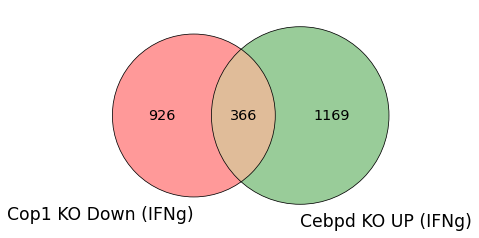

In [139]:
down_cop1 = set(ifn_rna_diff[(ifn_rna_diff['padj']<0.05) & (ifn_rna_diff['log2FoldChange']<0)]['gene'].unique())
up_cebpd = set(cebpd_ifn_diff[(cebpd_ifn_diff['padj']<0.05) & (cebpd_ifn_diff['log2FoldChange']>0)]['gene'].unique())
num_cop1_down, num_cebpd_up,  num_inter = venn_diagram(len(down_cop1 & up_cebpd), len(down_cop1), len(up_cebpd), 'Cop1 KO Down (IFNg)', 'Cebpd KO UP (IFNg)')
down_up_or, down_up_pval = stats.fisher_exact(
    [[num_inter, num_cebpd_up],
    [num_cop1_down, num_all_genes_ifn - num_inter - num_cebpd_up - num_cop1_down]])
plt.savefig('figures/venn_diagram_overlap_down_cop1_up_cebpd_ifng.pdf')

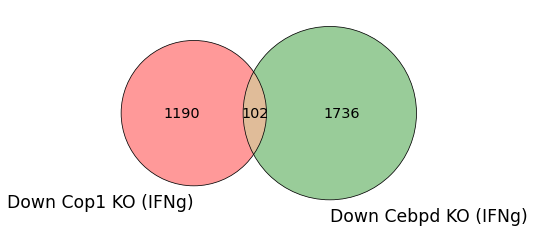

In [122]:
down_cop1 = set(ifn_rna_diff[(ifn_rna_diff['padj']<0.05) & (ifn_rna_diff['log2FoldChange']<0)]['gene'].unique())
down_cebpd = set(cebpd_ifn_diff[(cebpd_ifn_diff['padj']<0.05) & (cebpd_ifn_diff['log2FoldChange']<0)]['gene'].unique())
num_cop1_down, num_cebpd_down, num_inter = venn_diagram(len(down_cop1 & down_cebpd), len(down_cop1), len(down_cebpd), 'Down Cop1 KO (IFNg)', 'Down Cebpd KO (IFNg)')
mymat = [[num_inter, num_cebpd_down],
         [num_cop1_down, num_all_genes_ifn - num_inter - num_cebpd_down - num_cop1_down]]
down_down_or, down_down_pval = stats.fisher_exact(mymat)

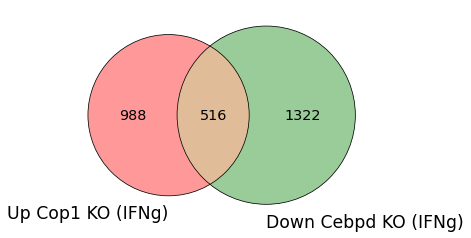

In [124]:
up_cop1 = set(ifn_rna_diff[(ifn_rna_diff['padj']<0.05) & (ifn_rna_diff['log2FoldChange']>0)]['gene'].unique())
down_cebpd = set(cebpd_ifn_diff[(cebpd_ifn_diff['padj']<0.05) & (cebpd_ifn_diff['log2FoldChange']<0)]['gene'].unique())
num_cop1_down, num_cebpd_up, num_inter = venn_diagram(len(up_cop1 & down_cebpd), len(up_cop1), len(down_cebpd), 'Up Cop1 KO (IFNg)', 'Down Cebpd KO (IFNg)')
mymat = [[num_inter, num_cebpd_up],
         [num_cop1_down, num_all_genes_ifn - num_inter - num_cebpd_up - num_cop1_down]]
up_down_or, up_down_pval = stats.fisher_exact(mymat)

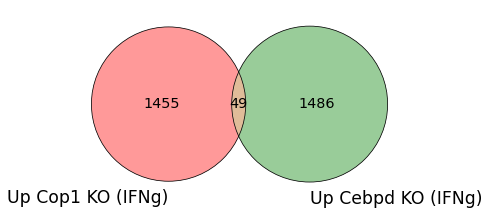

In [125]:
up_cop1 = set(ifn_rna_diff[(ifn_rna_diff['padj']<0.05) & (ifn_rna_diff['log2FoldChange']>0)]['gene'].unique())
up_cebpd = set(cebpd_ifn_diff[(cebpd_ifn_diff['padj']<0.05) & (cebpd_ifn_diff['log2FoldChange']>0)]['gene'].unique())
num_cop1_up, num_cebpd_up, num_inter = venn_diagram(len(up_cop1 & up_cebpd), len(up_cop1), len(up_cebpd), 'Up Cop1 KO (IFNg)', 'Up Cebpd KO (IFNg)')
mymat = [[num_inter, num_cebpd_up],
         [num_cop1_up, num_all_genes_ifn - num_inter - num_cebpd_up - num_cop1_up]]
up_up_or, up_up_pval = stats.fisher_exact(mymat)

/Users/ctokheim/conda/envs/data_analysis2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


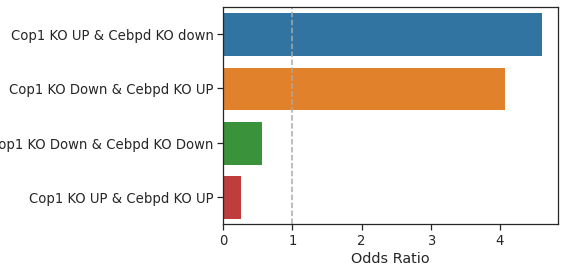

In [137]:
myseries = pd.Series([up_down_or, down_up_or, down_down_or, up_up_or], index=['Cop1 KO UP & Cebpd KO down', 'Cop1 KO Down & Cebpd KO UP', 'Cop1 KO Down & Cebpd KO Down', 'Cop1 KO UP & Cebpd KO UP'])
with sns.axes_style('ticks'), sns.plotting_context('notebook', font_scale=1.2):
    sns.barplot(myseries, myseries.index,  orient='h')
    plt.xlabel('Odds Ratio')
    plt.axvline(1, linestyle='--', color='darkgray')
    plt.savefig('figures/deg_overlap_ifng_cebpd_cop1.pdf')

In [141]:
print(up_down_pval)
print(down_up_pval)
print(down_down_pval)
print(up_up_pval)

5.1066998711930466e-120
3.709960639904858e-79
1.4064579787463615e-08
1.9638488676737966e-28


#### Overlap w/o IFNG

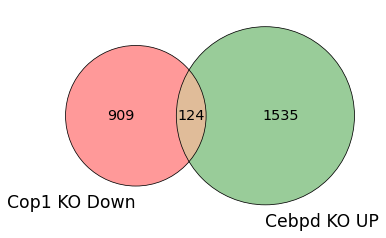

In [147]:
down_cop1 = set(rna_diff[(rna_diff['padj']<0.05) & (rna_diff['log2FoldChange']<0)]['gene'].unique())
up_cebpd = set(cebpd_diff[(cebpd_diff['padj']<0.05) & (cebpd_diff['log2FoldChange']>0)]['gene'].unique())
num_cop1_down, num_cebpd_up,  num_inter = venn_diagram(len(down_cop1 & up_cebpd), len(down_cop1), len(up_cebpd), 'Cop1 KO Down', 'Cebpd KO UP')
down_up_or, down_up_pval = stats.fisher_exact(
    [[num_inter, num_cebpd_up],
    [num_cop1_down, num_all_genes - num_inter - num_cebpd_up - num_cop1_down]])
plt.savefig('figures/venn_diagram_overlap_down_cop1_up_cebpd.pdf')

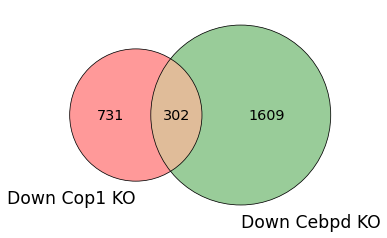

In [148]:
down_cop1 = set(rna_diff[(rna_diff['padj']<0.05) & (rna_diff['log2FoldChange']<0)]['gene'].unique())
down_cebpd = set(cebpd_diff[(cebpd_diff['padj']<0.05) & (cebpd_diff['log2FoldChange']<0)]['gene'].unique())
num_cop1_down, num_cebpd_down, num_inter = venn_diagram(len(down_cop1 & down_cebpd), len(down_cop1), len(down_cebpd), 'Down Cop1 KO', 'Down Cebpd KO')
mymat = [[num_inter, num_cebpd_down],
         [num_cop1_down, num_all_genes - num_inter - num_cebpd_down - num_cop1_down]]
down_down_or, down_down_pval = stats.fisher_exact(mymat)

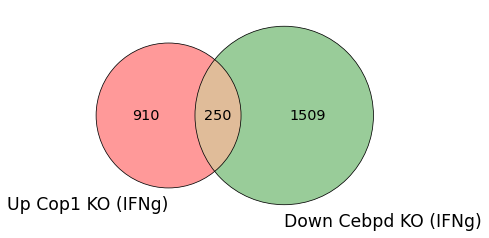

In [145]:
up_cop1 = set(rna_diff[(rna_diff['padj']<0.05) & (rna_diff['log2FoldChange']>0)]['gene'].unique())
down_cebpd = set(cebpd_diff[(cebpd_ifn_diff['padj']<0.05) & (cebpd_diff['log2FoldChange']<0)]['gene'].unique())
num_cop1_down, num_cebpd_up, num_inter = venn_diagram(len(up_cop1 & down_cebpd), len(up_cop1), len(down_cebpd), 'Up Cop1 KO', 'Down Cebpd KO')
mymat = [[num_inter, num_cebpd_up],
         [num_cop1_down, num_all_genes- num_inter - num_cebpd_up - num_cop1_down]]
up_down_or, up_down_pval = stats.fisher_exact(mymat)

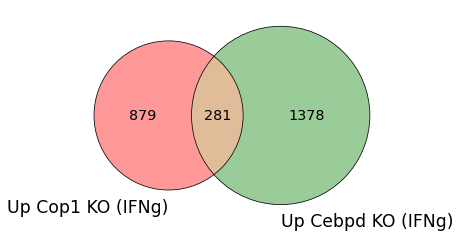

In [146]:
up_cop1 = set(rna_diff[(rna_diff['padj']<0.05) & (rna_diff['log2FoldChange']>0)]['gene'].unique())
up_cebpd = set(cebpd_diff[(cebpd_diff['padj']<0.05) & (cebpd_diff['log2FoldChange']>0)]['gene'].unique())
num_cop1_up, num_cebpd_up, num_inter = venn_diagram(len(up_cop1 & up_cebpd), len(up_cop1), len(up_cebpd), 'Up Cop1 KO', 'Up Cebpd KO')
mymat = [[num_inter, num_cebpd_up],
         [num_cop1_up, num_all_genes - num_inter - num_cebpd_up - num_cop1_up]]
up_up_or, up_up_pval = stats.fisher_exact(mymat)

/Users/ctokheim/conda/envs/data_analysis2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


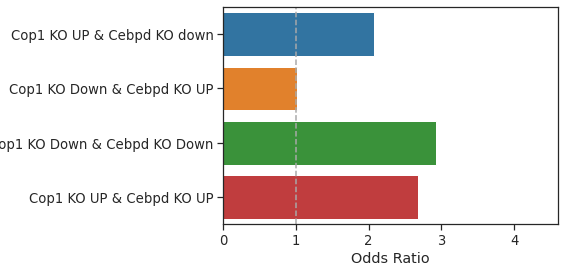

In [153]:
myseries = pd.Series([up_down_or, down_up_or, down_down_or, up_up_or], index=['Cop1 KO UP & Cebpd KO down', 'Cop1 KO Down & Cebpd KO UP', 'Cop1 KO Down & Cebpd KO Down', 'Cop1 KO UP & Cebpd KO UP'])
with sns.axes_style('ticks'), sns.plotting_context('notebook', font_scale=1.2):
    sns.barplot(myseries, myseries.index,  orient='h')
    plt.xlabel('Odds Ratio')
    plt.axvline(1, linestyle='--', color='darkgray')
    plt.xlim(0, 4.6)
    plt.savefig('figures/deg_overlap_cebpd_cop1.pdf')

In [150]:
print(up_down_pval)
print(down_up_pval)
print(down_down_pval)
print(up_up_pval)

2.2610843493627545e-19
0.8411577010941818
8.563240547566512e-43
3.88980769504814e-35


### Examine enrichment terms for CEBPD peaks

In [3]:
# read in data
cebpd_up = pd.read_csv('data/peaks/cebpd/enrichment/cebpd_up_peak_go_bp_result.txt', sep='\t', skiprows=8).sort_values('p_value')
#cebpd_down = pd.read_csv('data/peaks/cebpd/enrichment/cebpd_down_peak_go_bp_result.txt', sep='\t', skiprows=8).sort_values('p_value')

# get rid of GO number
cebpd_up['term'] = cebpd_up['# Term'].str.split('(', expand=True)[0]
#cebpd_down['term'] = cebpd_down['# Term'].str.split('(', expand=True)[0]

# -log10
cebpd_up['-log10(q-value)'] = -np.log10(cebpd_up['FDR'])
#cebpd_down['-log10(q-value)'] = -np.log10(cebpd_down['FDR'])

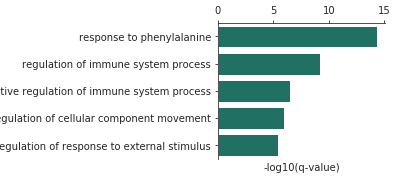

In [9]:
with sns.axes_style('ticks'):
    ax = sns.barplot(cebpd_up['-log10(q-value)'].head(5), cebpd_up['term'].head(5), color=sns.xkcd_rgb['blue green'])
    plt.ylabel('')
    sns.despine(bottom=True, top=False)
    ax.xaxis.set_ticks_position('top')
    plt.gcf().set_size_inches(3, 2.5)
    plt.savefig('figures/cebpd_up_peaks_go_enrichment_v3.pdf')

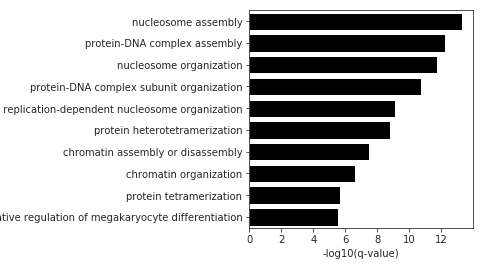

In [80]:
with sns.axes_style('ticks'):
    sns.barplot(cebpd_down['-log10(q-value)'].head(10), cebpd_down['term'].head(10), color='black')
    plt.ylabel('')
    plt.gcf().set_size_inches(4, 4)
    plt.savefig('figures/cebpd_down_peaks_go_enrichment.pdf')